# ML - Fall 2023 - Practical - 2
## Practical Homework 2 - Naive Bayes

Student Number: 400108547

Student Name: Parham Rezaei




# Phase 0: Intro

**In this assignment, you will develop Naive Bayes models to perform text classification. The dataset contains texts and the feelings correspond to each text. Your goal is to make a model to predict the emotion associated with each given text.**

Importing necessary libraries

In [39]:
import nltk
import pandas
import sklearn
import string
import spacy
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# Warning
There are some warnings in the results that are due to some mismatch. It is just saying something is deprecated. Nothing to do with my implementation :)

In [38]:
!pip install nltk

In [40]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [41]:
!wget -O dataset.csv https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1

In [44]:
#because of kaggle being stupid when downloading nltk stuff
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# Phase 1: Explore

## Sec 1: Load and Explore the given dataset **(P1-Sec1: 10 Points)**

Load the dataset. Look at the head of dataset. How many rows are there in the dataset? **(P1-1-1: 2 points)**




In [45]:
df = pd.read_csv('/kaggle/input/dataset4/dataset.csv')
df.head()
print(len(df.index))

5937


Handle missing values **(P1-1-2: 2 pints)**

In [46]:
# number of missing values (spoiler: none)
print(df.isnull().sum())
# check for empty feeling
df[df['Feeling'].str.strip().astype(bool) == False]

Text       0
Feeling    0
dtype: int64


,Text,Feeling


Identify the unique feeling values and for each of them, print their count in the dataset. **(P1-1-3: 2 points)**

In [47]:
# unique values 
print(f"unique values: {df['Feeling'].unique()}")
# count 
df['Feeling'].value_counts()

unique values: ['fear' 'anger' 'joy']


Feeling
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

Plot a pie chart to display the occurance frequency of each genre that you found in the prevoius part. **(P1-1-4: 2 points)**

<Axes: ylabel='count'>

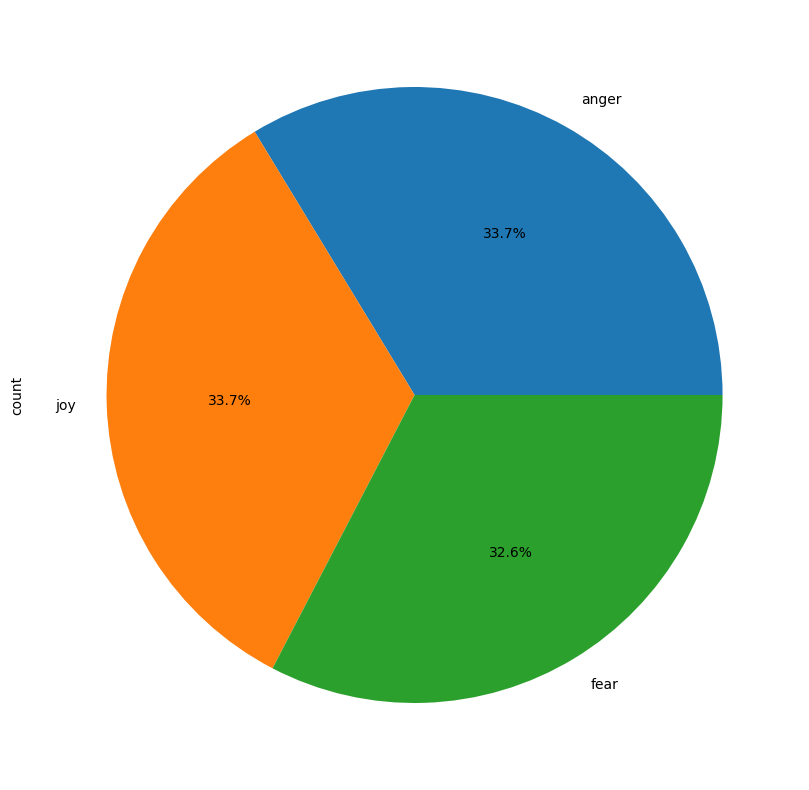

In [48]:
df['Feeling'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

Find the mean, max and min values of the length (in chars) of the Text Column. **(P1-1-5: 2 points)**


In [49]:
print(f"mean:{df['Text'].str.len().mean()}")
print(f"max:{df['Text'].str.len().max()}")
print(f"min:{df['Text'].str.len().min()}")

mean:97.42597271349166
max:298
min:9


# Phase 2: Preprocessing

## Sec 1: Preprocess the data **(P2-Sec1: 20 Points)**

In [50]:
class Preprocessor:

    def preprocess(self, text):
        # do the following functions in proper order
        text = self.remove_links_and_tags(text)
        words = self.word_tokenize(text)
        words = self.remove_stopwords(words)
        words = self.remove_punctuations(words)
        words = self.normalize(words)
        joined = ' '.join(words)
        return joined

    def remove_links_and_tags(self, text):
        text = re.sub(r"http\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
        return text

    def word_tokenize(self, text):
        return word_tokenize(text)

    def remove_stopwords(self, words):
        stop_words = set(stopwords.words('english'))
        return [w for w in words if w.lower() not in stop_words]

    def remove_punctuations(self, words):
        return [w.translate(str.maketrans('', '', string.punctuation)) for w in words]

    def normalize(self, words):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word.lower()) for word in words]

Inspect the dataset for any empty cells or duplicate rows, and if they are present, remove the corresponding rows from the dataset. **(P2-1-1: 5 points)**

In [51]:
print(df[df.duplicated()])
print(df[df['Text'].str.strip().astype(bool) == False])
# none but If the was something I would do
df = df.dropna()
df = df.drop_duplicates()

Empty DataFrame
Columns: [Text, Feeling]
Index: []
Empty DataFrame
Columns: [Text, Feeling]
Index: []


Clean the Texts by removing the special characters and punctations. **(P2-1-2: 5 points)**

In [52]:
#clean texts by removing special chars and punctuations by Preprocessor class
preprocessor = Preprocessor()
df['Text'] = df['Text'].apply(preprocessor.remove_links_and_tags)
df['Text'] = df['Text'].str.replace("[^a-zA-Z#]", " ")
def split_bef(string):
    ws = string.split()
    ws = preprocessor.remove_punctuations(ws)
    return " ".join(ws)
df['Text'] = df['Text'].apply(split_bef)
df.head()

,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


Remove the stop-words from the synopsis texts. Stop-words are those that have a high frequency in the language but don't have much information like 'the', 'and', 'to', etc. **(P2-1-3: 5 points)**

In [53]:
def stop_words_remover(string):
    ws = string.split()
    return ' '.join(preprocessor.remove_stopwords(ws))
df['Text'] = df['Text'].apply(stop_words_remover)
df.head()

,Text,Feeling
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,joy
4,feel suspicious one outside like rapture happe...,fear


Tokenize the text and convert all characters to their lowercased version **(P2-1-4: 5 points)**

In [54]:
def tokenizer_2(string):
    ws = preprocessor.word_tokenize(string)
    return [x.lower() for x in ws]
df['Tokens'] = df['Text'].apply(tokenizer_2)
df.head()

,Text,Feeling,Tokens
0,seriously hate one subject death feel reluctan...,fear,"[seriously, hate, one, subject, death, feel, r..."
1,im full life feel appalled,anger,"[im, full, life, feel, appalled]"
2,sit write start dig feelings think afraid acce...,fear,"[sit, write, start, dig, feelings, think, afra..."
3,ive really angry r feel like idiot trusting fi...,joy,"[ive, really, angry, r, feel, like, idiot, tru..."
4,feel suspicious one outside like rapture happe...,fear,"[feel, suspicious, one, outside, like, rapture..."


In [55]:
df['Text'] = df['Tokens'].apply(lambda x: ' '.join(x))
df.head()

,Text,Feeling,Tokens
0,seriously hate one subject death feel reluctan...,fear,"[seriously, hate, one, subject, death, feel, r..."
1,im full life feel appalled,anger,"[im, full, life, feel, appalled]"
2,sit write start dig feelings think afraid acce...,fear,"[sit, write, start, dig, feelings, think, afra..."
3,ive really angry r feel like idiot trusting fi...,joy,"[ive, really, angry, r, feel, like, idiot, tru..."
4,feel suspicious one outside like rapture happe...,fear,"[feel, suspicious, one, outside, like, rapture..."


In [56]:
df['Text'] = df['Tokens'].apply(preprocessor.normalize)
df.head()

,Text,Feeling,Tokens
0,"[seriously, hate, one, subject, death, feel, r...",fear,"[seriously, hate, one, subject, death, feel, r..."
1,"[im, full, life, feel, appalled]",anger,"[im, full, life, feel, appalled]"
2,"[sit, write, start, dig, feeling, think, afrai...",fear,"[sit, write, start, dig, feelings, think, afra..."
3,"[ive, really, angry, r, feel, like, idiot, tru...",joy,"[ive, really, angry, r, feel, like, idiot, tru..."
4,"[feel, suspicious, one, outside, like, rapture...",fear,"[feel, suspicious, one, outside, like, rapture..."


In [57]:
df['Text'] = df['Text'].apply(lambda x: ' '.join(x))
df.head()

,Text,Feeling,Tokens
0,seriously hate one subject death feel reluctan...,fear,"[seriously, hate, one, subject, death, feel, r..."
1,im full life feel appalled,anger,"[im, full, life, feel, appalled]"
2,sit write start dig feeling think afraid accep...,fear,"[sit, write, start, dig, feelings, think, afra..."
3,ive really angry r feel like idiot trusting fi...,joy,"[ive, really, angry, r, feel, like, idiot, tru..."
4,feel suspicious one outside like rapture happe...,fear,"[feel, suspicious, one, outside, like, rapture..."


In [58]:
df['Feeling'] = df['Feeling'].map({'anger':0, 'joy':1, 'fear':2})

# Phase 3: Training

## Sec 1: Preparing the training feed **(P3-Sec1: 20 Points)**

Extract the "X" and "y" numpy array from columns corresponding to text and feelings. **(P3-1-1: 5 Points)**

In [59]:
X = df['Text']
y = df['Feeling']

Split the dataset into two parts such that the training set (denoted as `x_train` and ‍`y_train`) contains 80% of the samples. **(P3-1-2: 5 Points)**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Extract the text embeddings (feature vectors) for all the texts in the dataset. **(P3-1-3: 10 Points)**

For this task you can use **tf-idf** or **count vectorizer**. Search about them!

In [61]:
X_train.head()

2451                       id feeling paranoid going bald
4731    necessarily think f bomb sex necessary story f...
3814    may bit late year im feeling festive sat fire ...
565                               feel rich pas see penny
4544    usually feel suspicious guilty considering lit...
Name: Text, dtype: object

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test)

In [63]:
# just to know
u = X_train.toarray()
print(u.shape)

(4749, 7043)


## Sec 2: Naive Bayes from Scratch **(P3-Sec2: 20 Points)**

Complete this section with your code. **(P3-2: 20 points)**

In [64]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1):

        '''
        Initialize these:

        Laplace smoothing parameter
        P(Y)
        P(X_i | Y)
        '''

        # initialize laplace smoothing parameter
        self.alpha = alpha
        self.classprobs = defaultdict()
        self.xiy = None

    def fit(self, X, y):

        '''
        Calculate class probabilities P(Y)

        Calculate word probabilities P(X_i | Y)
        '''
        self.classprobs = defaultdict()
        for i in range(len(y)):
            if y[i] not in self.classprobs:
                self.classprobs[y[i]] = 1
            else:
                self.classprobs[y[i]] += 1
        xiy = {0:np.zeros(len(X[0])), 1:np.zeros(len(X[0])), 2:np.zeros(len(X[0]))}
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j] != 0:
                    xiy[y[i]][j] += X[i][j]
        for i in range(len(xiy)):
            xiy[i] = (xiy[i] + self.alpha) / (sum(xiy[i]) + self.alpha * len(xiy[i]))
        self.xiy = xiy


    def predict(self, X):

        '''
        Calculate the log likelihood of the sample for each class

        Predict the class with the highest score
        '''
        y_pred = []
        for i in range(len(X)):
            log_likelihood = np.zeros(len(self.classprobs))
            for j in range(len(self.classprobs)):
                log_likelihood[j] = np.log(self.classprobs[j])
                for k in range(len(X[i])):
                    if X[i][k] != 0:
                        log_likelihood[j] += np.log(self.xiy[j][k])
            y_pred.append(np.argmax(log_likelihood))

        return y_pred

## Sec 3: Fit models to the training data **(P3-Sec3: 10 Points)**

Fit a Naive Bayes classifier to the data. (Use both regressors - sklearn & from scratch) **(P3-3-1: 10 points)**

In [65]:
skclf = MultinomialNB()
skclf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MultinomialNB()

In [66]:
# mine
clf = NaiveBayesClassifier()
clf.fit(X_train.toarray(), y_train.to_numpy())

# Phase 4: Evaluation

## Sec 1: Evaluate both models and compare the results (P4-Sec1: 20 points)

Predict the value of "y" for each "x" belonging to the "testing" set (use both models) **(P4-1-1: 5 points)**

In [67]:
sky_pred = skclf.predict(X_test)
print(f"sklearn accuracy:{accuracy_score(y_test, sky_pred)}")

sklearn accuracy:0.9031986531986532


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [68]:
y_pred = clf.predict(X_test.toarray())
print(f"my accuracy:{accuracy_score(y_test, y_pred)}")

my accuracy:0.9074074074074074


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Compute Confusion matrix and classification report for each model **(P4-1-2: 10 points)**

In [69]:
print("sklearn confusion matrix")
print(confusion_matrix(y_test, sky_pred))
print("my confusion matrix")
print(confusion_matrix(y_test, y_pred))

sklearn confusion matrix
[[349  13  19]
 [ 31 367  25]
 [ 21   6 357]]
my confusion matrix
[[352  10  19]
 [ 30 368  25]
 [ 20   6 358]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [70]:
print("sklearn classification report")
print(classification_report(y_test, sky_pred))
print("my classification report")
print(classification_report(y_test, y_pred))

sklearn classification report
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       381
           1       0.95      0.87      0.91       423
           2       0.89      0.93      0.91       384

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.91      0.90      0.90      1188

my classification report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       381
           1       0.96      0.87      0.91       423
           2       0.89      0.93      0.91       384

    accuracy                           0.91      1188
   macro avg       0.91      0.91      0.91      1188
weighted avg       0.91      0.91      0.91      1188



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Explain the results of the previous section (what is f1-score? - what is the recall? - what is precision?), also compare the model's performance **(P4-1-3: 5 points)**

for f1 the formula is 2/(1/precision + 1/recall)
recall gives us the ratio of true positives on all positives samples. (tp/(tp+fn))
precision gives us acurately classed positives on all predicted to be positive : (tp/(tp+fp))
notice positive/neg I mean for each class of ours as you can see in the classification report
They are all close between my model and sklearns. but mine is 0.01 better on the precision of class 2.

Model Performance Intuition Part: Now, you can test whether your model has a good prediction for a random text.

In [71]:
example = preprocessor.preprocess("The food is quite delicious")
res = clf.predict(vectorizer.transform([example]).toarray())[0]
if res == 0:
    print("anger")
elif res == 1:
    print("joy")
else:
    print("fear")

joy


# Phase 5: Neural Net (Bonus)

In [20]:
#importing stuff
!pip install gensim
!pip install spacy
!python3.11 -m spacy download en_core_web_sm
import gensim
import pandas as pd
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
word2vec_path = '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path,binary=True)


/bin/bash: line 1: python3.11: command not found


Make a list of words available in the dataset

In [36]:
df = df.reset_index()
texts = df['Text'].to_list()

Retrieve the Word2Vec embeddings for each word

In [21]:
texts = [[token for token in text.split() if token in w2v.key_to_index] for text in texts]
mapped_texts = [[w2v.key_to_index[token] for token in tokens_list] for tokens_list in texts]

Train a neural network consisting of LSTM and Fully-Connected layers to perform text classification **(P5-1: 8 points)**

In [22]:
#labels
onehot = pd.get_dummies(df['Feeling'])
onehot[0] = onehot[0].apply(lambda x: int(x))
onehot[1] = onehot[1].apply(lambda x: int(x))
onehot[2] = onehot[2].apply(lambda x: int(x))

In [23]:
# make lengths the same
def pad_seq(seq, max_len = 10):
    if len(seq) < max_len:
        seq = np.pad(seq, (0, max_len - len(seq)), 'constant')
    elif len(seq) > max_len:
        seq = seq[:max_len]
    return seq

In [30]:
x_train, x_v, y_train, y_v = train_test_split(mapped_texts, onehot, test_size=0.1, random_state=34)
x_test, x_val, y_test, y_val = train_test_split(x_v, y_v, test_size=0.5, random_state=34)
BATCH_SIZE = 32
class MyDataset(Dataset):#configured for my 3 labels format
    def __init__(self, mapped_texts, labels):
        self.token_lists = [pad_seq(mt) for mt in mapped_texts]
        self.labels = np.array(labels).reshape(-1, 3)
    def __len__(self):
        return len(self.token_lists)
    def __getitem__(self, idx):   
        return torch.LongTensor(self.token_lists[idx]).cuda(), torch.Tensor(self.labels[idx]).cuda()

train_dataloader = DataLoader(MyDataset(x_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(MyDataset(x_test,y_test), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(MyDataset(x_val,y_val), batch_size=BATCH_SIZE, shuffle=True)

class lstmModel(nn.Module):
    def __init__(self):
        super(lstmModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v.vectors))
        self.lstm = nn.LSTM(input_size=300, hidden_size=300, batch_first=True)
        self.l1 = nn.Linear(300, 3)
        self.a1 = nn.Sigmoid()
    
    def forward(self, x):
        output = self.embedding(x)
        output, _ = self.lstm(output) 
        output = self.l1(output[:, -1, :]) 
        output = self.a1(output)
        return output

In [31]:
model = lstmModel().cuda()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [32]:
model

lstmModel(
  (embedding): Embedding(3000000, 300)
  (lstm): LSTM(300, 300, batch_first=True)
  (l1): Linear(in_features=300, out_features=3, bias=True)
  (a1): Sigmoid()
)

Evaluate the neural net on the training and testing data from the section *3-1-2*. **(P5-2: 2 points)**

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_num):
    num_points = len(dataloader.dataset)
    for batch, (features, labels) in enumerate(dataloader):
        pred = model(features)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"\r Epoch {epoch_num} - loss: {loss:>7f}  [{current:>5d}/{num_points:>5d}]", end=" ")

def test_loop(dataloader, model, loss_fn, epoch_num, name):
    num_points = len(dataloader.dataset)
    sum_test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (features, labels) in enumerate(dataloader):
            pred = model(features)
            sum_test_loss += loss_fn(pred, labels).item() 
            pred_lst = list(pred.cpu().detach().numpy().squeeze())
            pred_lst = [np.argmax(item) for item in pred_lst]
            output_lst = list(labels.cpu().detach().numpy().squeeze()) 
            output_lst = [np.argmax(i) for i in output_lst]
            match_lst = [1 if p==o else 0 for (p, o) in zip(pred_lst, output_lst)] 
            correct += sum(match_lst) 
            
    sum_test_loss /= num_points
    correct /= num_points
    print(f"\r Epoch {epoch_num} - {name} Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {sum_test_loss:>8f}", end=" ")

In [34]:
for epoch_num in range(1, 15):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num)
    test_loop(val_dataloader, model, loss_fn, epoch_num, 'Development/Validation')

 Epoch 14 - Development/Validation Error: Accuracy: 92.3%, Avg loss: 0.004879 

Note: To get the points, Your neural net's performance should be at least as good as the Naive Bayes classifier. The exact architecture of the neural net is up to you. You can use Pytorch or Tensorflow to train it.

In [35]:
test_loop(test_dataloader, model, loss_fn, epoch_num, 'Test')

 Epoch 14 - Test Error: Accuracy: 91.6%, Avg loss: 0.007293 

We see an improvement in the accuracy

# Phase 6 (Optional): Submit your predictions to our Kaggle competition

Competition Link: WILL BE ADDED HERE

I used RoBERTa for the competition. It is indeed a banger. The result is 97-98%